In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white', frameon=False)

# Import pangeapy modules

In [2]:
from pangeapy.cell import CellAnnotator
from pangeapy.meta import MetaAnnotator

In [3]:
cell_anno = CellAnnotator()
meta_anno = MetaAnnotator()

Checking-up download status of anno_models
Checking-up download status of meta_models


pangeapy provides two main interfaces:

- **CellAnnotator**: performs cell type annotation based on the pre-trained PANGEA model (built on top of CellTypist).
- **MetaAnnotator**: handles metadata-level annotations and harmonization tasks.

# Download and load the PBMC dataset

We use the 3k PBMC dataset from the official Scanpy tutorial.

In [4]:
# %%bash
# mkdir -p data write
# cd data
# test -f pbmc3k_filtered_gene_bc_matrices.tar.gz || curl https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o pbmc3k_filtered_gene_bc_matrices.tar.gz
# tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [5]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# Basic preprocessing

Here, we perform standard QC filtering following tutorial

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

filtered out 19024 genes that are detected in less than 3 cells


# Normalization and log transformation

⚠️ **Important**:
- Pangeapy expects log1p-normalized expression scaled to 10,000 counts per cell (similar to CellTypist).
- If you later modify `adata.X`, store the normalized expression in `adata.raw` to ensure compatibility.

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [9]:
adata.raw = adata.copy()

# Dimension reduction

In [10]:
sc.pp.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/smcheong/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


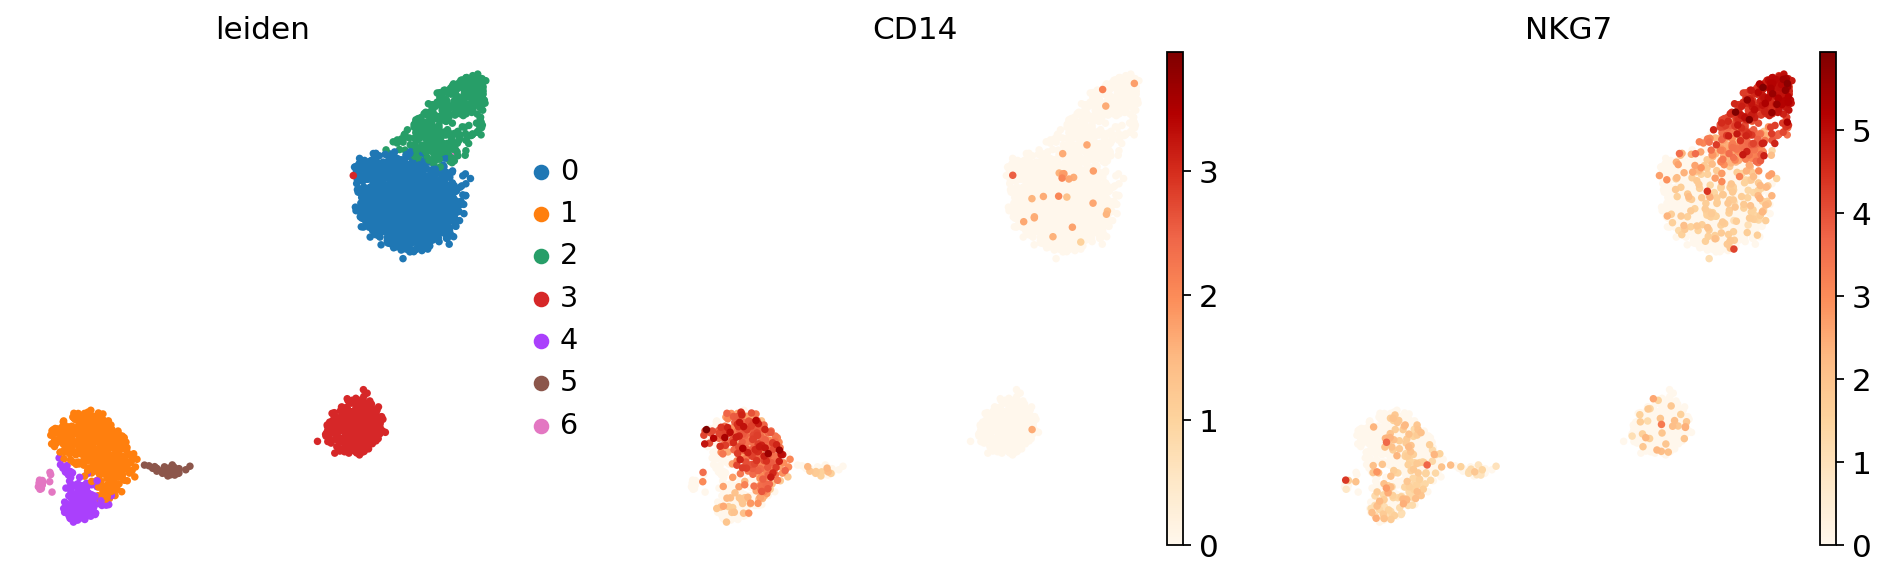

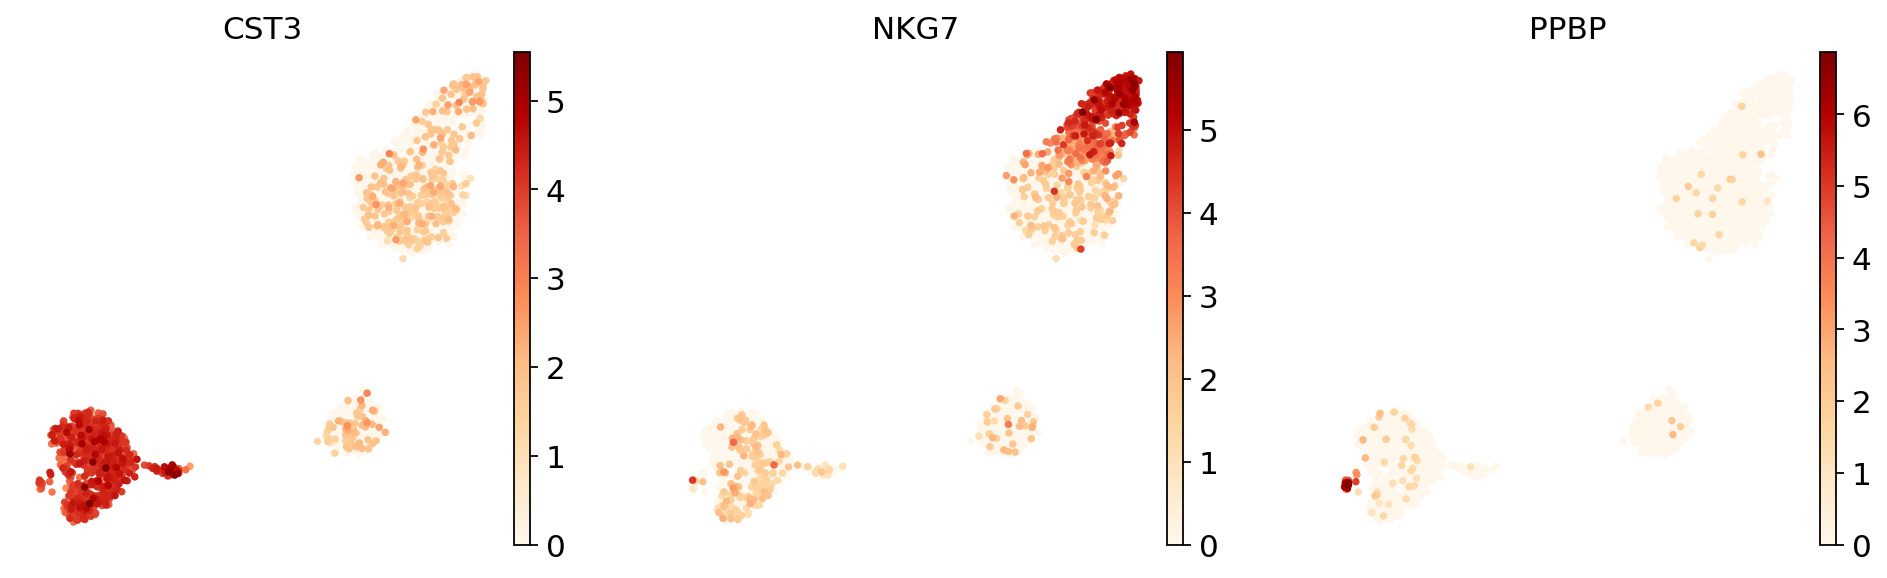

In [11]:
sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"], cmap='OrRd')
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], cmap='OrRd')

# Verify expression matrix and gene symbols

You can see here that while `adata.X` is scaled, the AnnData object stored in `adata.raw` contains log1p-normalized expression scaled to 10,000 counts per cell.

In [12]:
print(adata.X.max(), adata.X.min())

10.0 -10.0


In [13]:
raw_X = adata.raw.to_adata().X

print(raw_X.min(), raw_X.max())

0.0 7.4695992


In [14]:
np.expm1(raw_X).sum(axis=1)

matrix([[10000.   ],
        [10000.   ],
        [10000.001],
        ...,
        [10000.001],
        [10000.   ],
        [ 9999.999]], shape=(2638, 1), dtype=float32)

Ensure that gene symbols are properly formatted

In [15]:
adata.var.index[:10]

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4'],
      dtype='object')

# Cell type annotation with pangeapy

This step applies pangeapy's cell type prediction model.

In [16]:
pred = cell_anno.annotate(adata)

conducting Level1 annotation...
running Leiden clustering
    finished: found 58 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)
conducting Level2 annotation...
running Leiden clustering
    finished: found 54 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 58 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 83 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


Output columns `predicted_labels`, `majority_voting`, and `conf_score` follow the output format of CellTypist

In [17]:
pred.columns

Index(['Level1|predicted_labels', 'Level1|over_clustering',
       'Level1|majority_voting', 'Level1|conf_score', 'Level1|cert_score',
       'Level2|predicted_labels', 'Level2|over_clustering',
       'Level2|majority_voting', 'Level2|conf_score', 'Level2|cert_score',
       'PG_annotations', 'PG_combined_score', 'Sample'],
      dtype='object')

In [18]:
pred.head()

,Level1|predicted_labels,Level1|over_clustering,Level1|majority_voting,Level1|conf_score,Level1|cert_score,Level2|predicted_labels,Level2|over_clustering,Level2|majority_voting,Level2|conf_score,Level2|cert_score,PG_annotations,PG_combined_score,Sample
AAACATACAACCAC-1,T&NK,0,T&NK,0.999988,0.057514,T_CD8_EM,0,T_CD4_N&CM,0.999845,0.043247,T&NK|T_CD4_N&CM,0.999916,single-run
AAACATTGAGCTAC-1,B_mature,2,B_mature,0.997472,0.154506,Memory_atypical,0,Memory_switched,0.066986,0.766704,B_mature|Memory_switched,0.258490,single-run
AAACATTGATCAGC-1,T&NK,3,T&NK,0.999986,0.075099,T_CD4_EM_Th22,1,T_CD4_N&CM,0.998640,0.047488,T&NK|T_CD4_N&CM,0.999313,single-run
AAACCGTGCTTCCG-1,Monocyte,6,Monocyte,0.999985,0.049793,ISG,0,ISG,0.493210,0.946835,Monocyte|ISG,0.702284,single-run
AAACCGTGTATGCG-1,T&NK,7,T&NK,0.999961,0.045166,NK_CD16,2,NK_CD16,1.000000,0.040089,T&NK|NK_CD16,0.999980,single-run


The annotation results can be merged into the main AnnData object for visualization and downstream analyses.

In [19]:
adata.obs = pd.merge(
    adata.obs,
    pred.drop('Sample', axis=1),
    left_index=True, right_index=True, how='left'
)

In [20]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Level1|predicted_labels', 'Level1|over_clustering', 'Level1|majority_voting', 'Level1|conf_score', 'Level1|cert_score', 'Level2|predicted_labels', 'Level2|over_clustering', 'Level2|majority_voting', 'Level2|conf_score', 'Level2|cert_score', 'PG_annotations', 'PG_combined_score'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

... storing 'Level2|predicted_labels' as categorical
... storing 'Level2|over_clustering' as categorical
... storing 'Level2|majority_voting' as categorical
... storing 'PG_annotations' as categorical


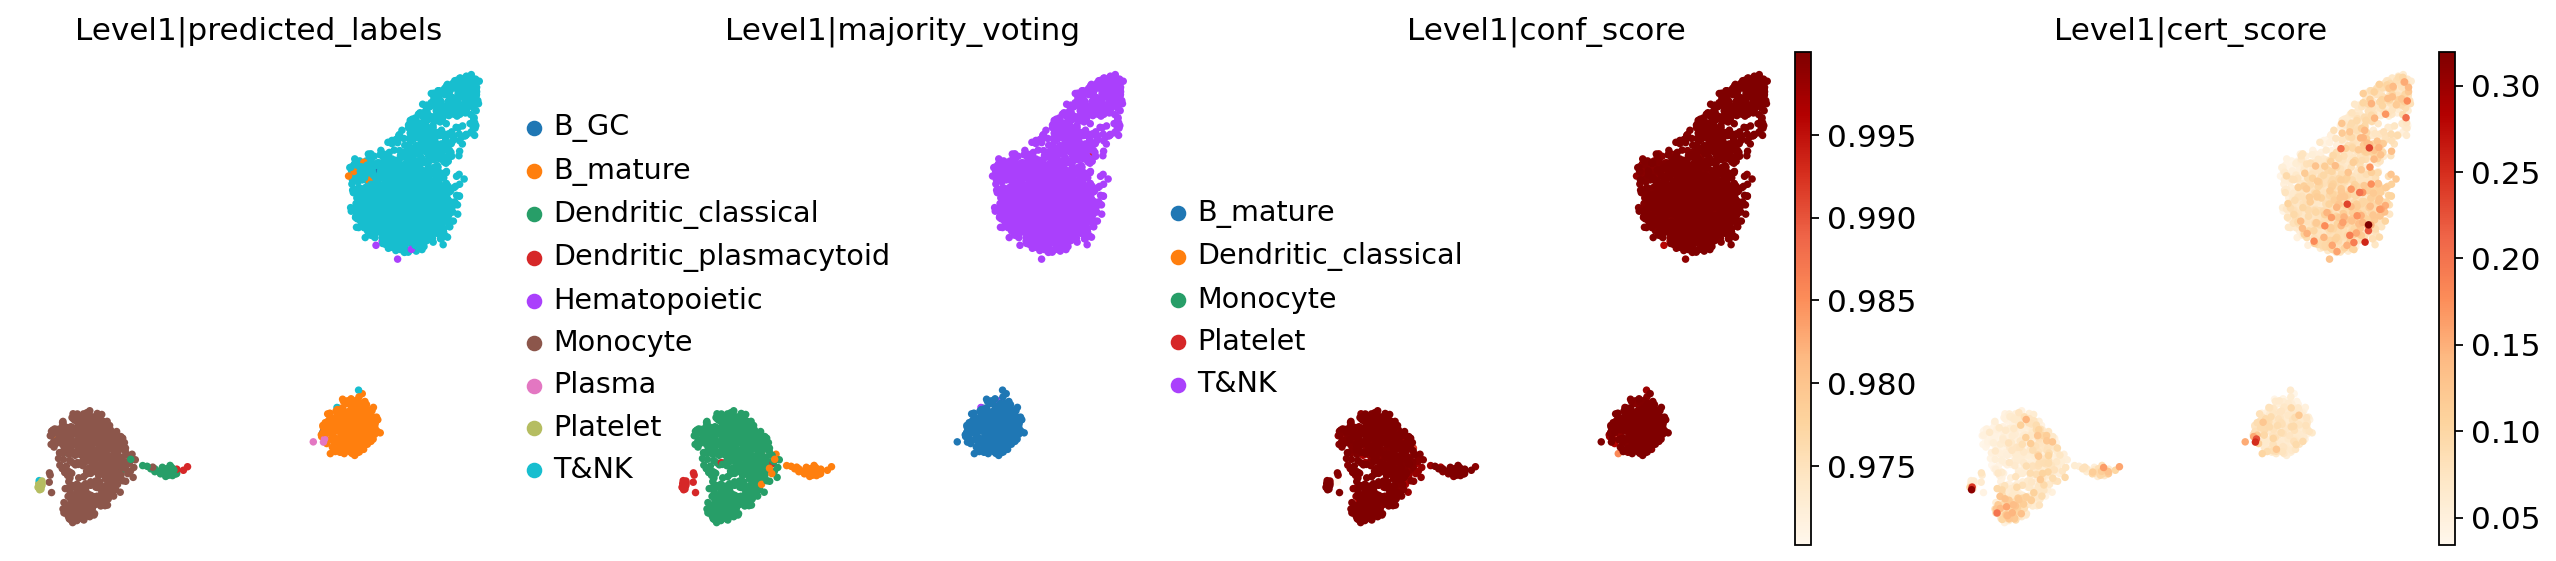

In [21]:
sc.pl.umap(
    adata, 
    color=['Level1|predicted_labels',  'Level1|majority_voting', 'Level1|conf_score', 'Level1|cert_score'],
    cmap='OrRd'
)

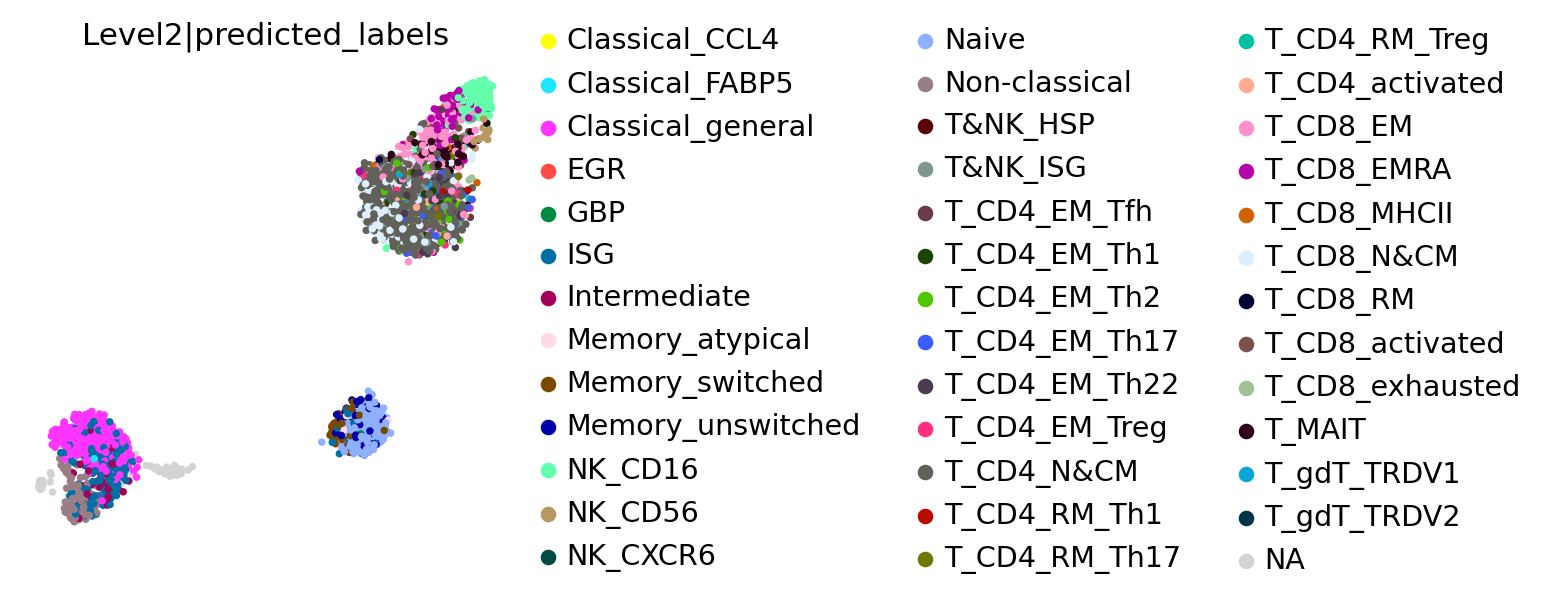

In [22]:
sc.pl.umap(adata, color='Level2|predicted_labels')

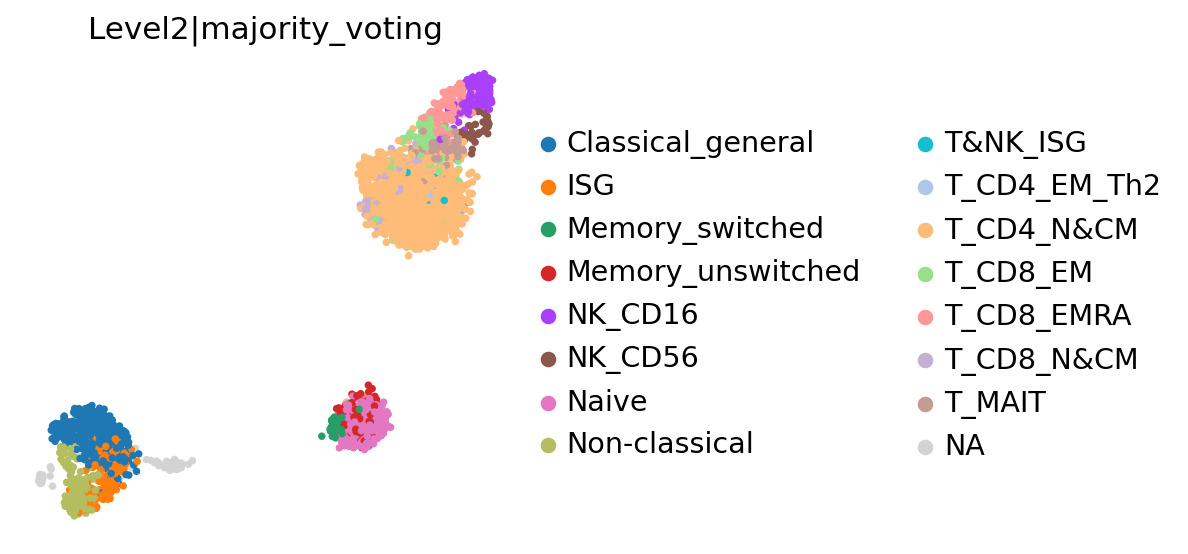

In [23]:
sc.pl.umap(adata, color='Level2|majority_voting')

The `PG_annotations` column represents the final annotation result from pangeapy, obtained by merging the Level1 and Level2 classification results.

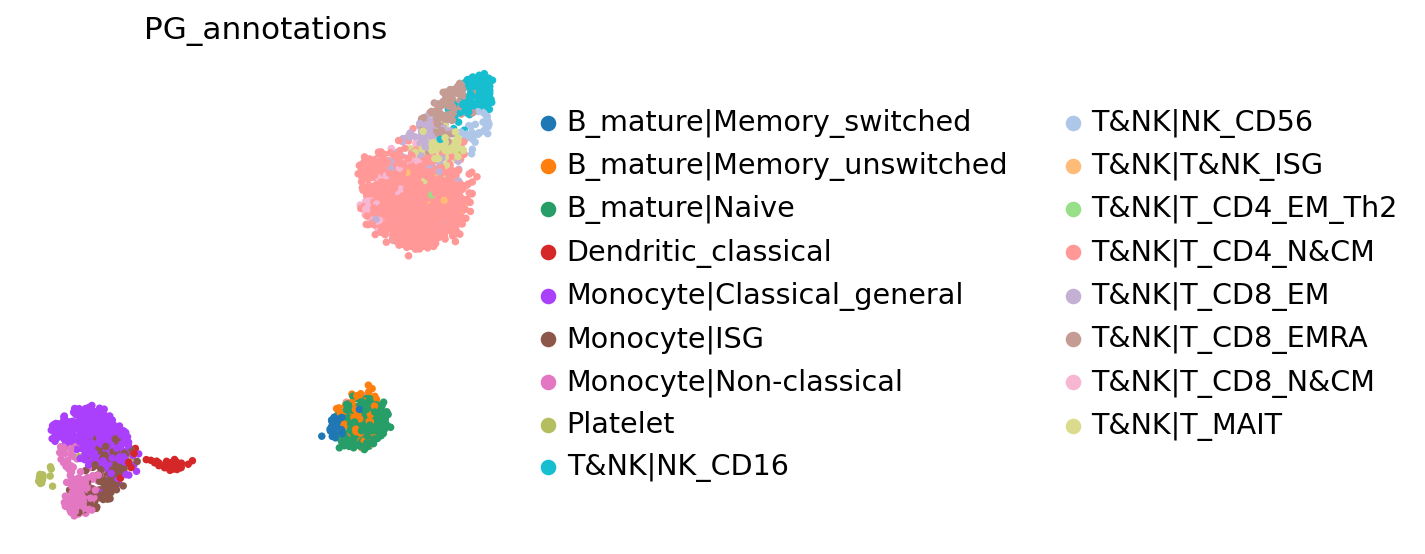

In [24]:
sc.pl.umap(adata, color='PG_annotations')

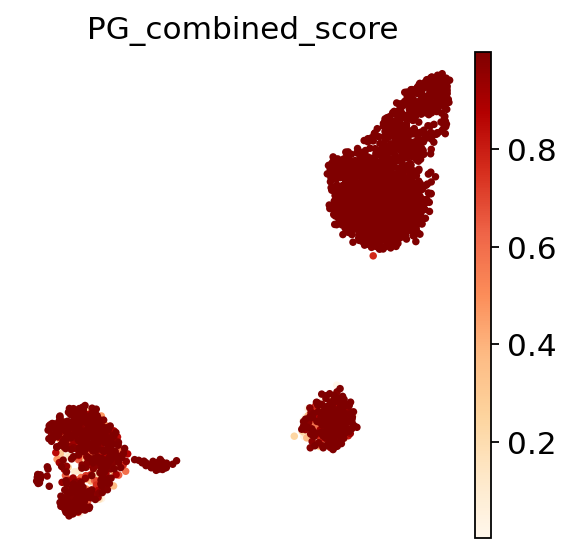

In [25]:
sc.pl.umap(adata, color='PG_combined_score', cmap='OrRd')